In [12]:
# Load modules
import sys

# third party
import matplotlib.pyplot as plt
import numpy as np
import sys
from pathlib import Path
import psyplot.project as psy
import pandas as pd
import xarray
from netCDF4 import Dataset,date2num
import metpy.calc as calc
from metpy.units import units
import datetime as dt
import pandas as pd
from iconarray.plot import formatoptions # import plotting formatoptions (for use with psyplot)
import iconarray as iconvis # import self-written modules from iconarray

# first party
sys.path.append('../mapplot/')
from timefunctions import *
import varfunctions as vf
import locfunctions as lf

In [13]:
## DECIDE ##
# where to save
plotpath_base = '/scratch/tlezuo/icon-vis/lidar/data/'
# from where to load
rs_path = '/users/tlezuo/data/2D/crossinn_rs/'

# decide which variables to calculate
pvars_list = []
cvars_list = []
# pvars_list.extend([vf.qv_2m,vf.T_2M])
pvars_list= [vf.VEL, vf.DIR, vf.T, vf.P, vf.ALT, vf.RH, vf.TD] 
cvars_list = [vf.U, vf.V,vf.TH,vf.TD,vf.QV]

# decide which time period to plot
startdate = dt.datetime(2019,9,12,23,00)
enddate = dt.datetime(2019,9,13,23,00)


In [14]:
## LOAD DATA ##

# create time lists
# time [str]
rstime_list = ['12_23','13_03','13_06','13_09','13_11','13_13','13_15','13_17','13_20','13_23']
# time [dt]
plotdates = [dt.datetime(2019,9,12,23,00),dt.datetime(2019,9,13,3,00),dt.datetime(2019,9,13,6,00),dt.datetime(2019,9,13,9,00),
dt.datetime(2019,9,13,11,00),dt.datetime(2019,9,13,13,00),dt.datetime(2019,9,13,15,00),dt.datetime(2019,9,13,17,00),dt.datetime(2019,9,13,20,00),dt.datetime(2019,9,13,23,00)]
# time [filename]
rsname_list = ['201909'+t+'UTC_L2.txt'for t in rstime_list]

# initialize dict
lidar_data_rs = {}
# fill arrays to call them next
for pvar in pvars_list:
    lidar_data_rs[pvar.name] = np.zeros((10,1701)) # 81 levels for halflevel-variables as W
for cvar in cvars_list:
    lidar_data_rs[cvar.name] = np.zeros((10,1701)) # 81 levels for halflevel-variables as W


# loop over sounding txt files
for counter,rstime in enumerate(rstime_list):
    # load filename
    rsname = rsname_list[counter]
    
    # read file
    rs_df = pd.read_fwf(rs_path+rsname,names=['time','P','T','RH','VEL','DIR','ALT','GEO','TD'],index_col=False)
    # drop first row
    rs_df.drop(index=rs_df.index[0], axis=0, inplace=True)
    
    # save each column in right dict location in dict
    for pvar in pvars_list:
            lidar_data_rs[pvar.name][counter] = rs_df[pvar.name][0:1701]
    

In [15]:
## CALCULATIONS ##

# TH 
lidar_data_rs['TH'] = vf.calculate_potT(lidar_data_rs['T'],lidar_data_rs['P'])
# TD
lidar_data_rs['TD']  = vf.calculate_tdew_from_rh(lidar_data_rs['RH'], lidar_data_rs['T'])
# QV
lidar_data_rs['QV']  = vf.calculate_qv_from_rh(lidar_data_rs['P'], lidar_data_rs['RH'], lidar_data_rs['T'])
# U, V
lidar_data_rs['U'],lidar_data_rs['V'] = calc.wind_components(lidar_data_rs['VEL']* units('m/s'),lidar_data_rs['DIR']* units.deg)
# T unit correction
lidar_data_rs['T'] = lidar_data_rs['T']+273.15


In [16]:
## SAVE LIDAR DATA ##
np.save('lidar_data_rs_Kolsass.npy', lidar_data_rs) 


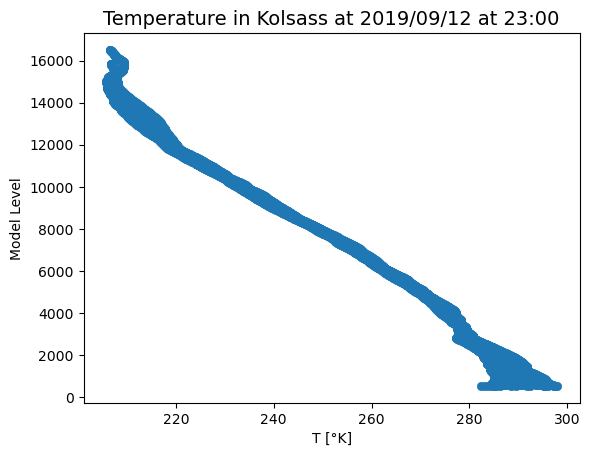

In [17]:
## TEST SINGLE PROFILE ##
pvar=vf.T
loc=lf.kols
pdate=dt.datetime(2019,9,12,23,00)

# Create plot of var_coord
f, axes = plt.subplots(1,1)                                                                                              
ax = axes                                                                                                                
h = ax.scatter(lidar_data_rs[pvar.name],  lidar_data_rs['ALT'], lw=0.5)
ax.set_xlabel(pvar.name+' '+pvar.units)
ax.set_ylabel('Model Level')
ax.set_title(pvar.title+' in '+loc.name + ' at ' +pdate.strftime('%Y/%m/%d at %H:%M'), fontsize=14)
# plt.ylim([0,20])
# plt.xlim([pvar.min,pvar.max]);
plt.show()

Text(0, 0.5, 'VEL [m/s]')

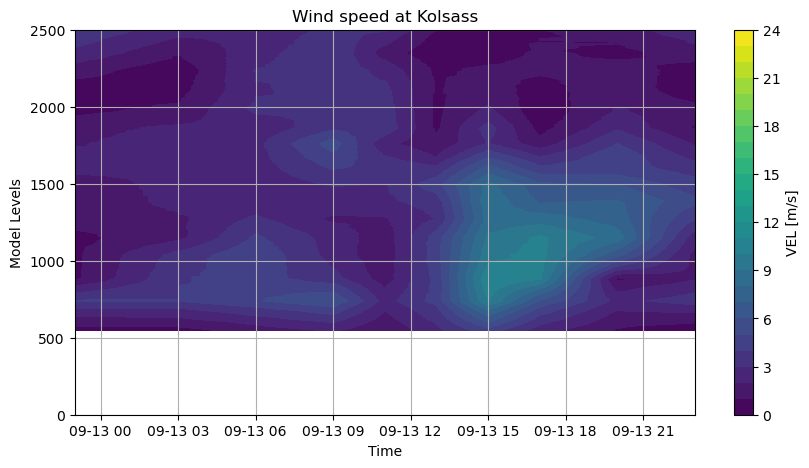

In [18]:
## TEST LIDAR PLOT ##
# select variable
pvar=vf.VEL
loc =lf.kols

# set data
x = plotdates
y = lidar_data_rs['ALT'][0]
z = np.transpose(lidar_data_rs[pvar.name])
levels = np.arange(pvar.min,pvar.max,pvar.ticks)
levels = np.arange(pvar.min,25,pvar.ticks)

#create plot
fig, ax = plt.subplots(1,1, figsize=(10,5))
plt.contourf(x,y,z, levels = levels)
cbar = plt.colorbar()
# add windbarbs
dx = 2
dy =1
q_scale = 30
q_width = 0.002
# ax.quiver(x[2::dx], y[::dy], 
#         np.transpose(lidar_data_rs['U'])[::dy, 2::dx], #U
#         np.transpose(lidar_data_rs['V'])[::dy, 2::dx], #V
#         scale=q_scale, scale_units='inches',
#         width=q_width)

# plotting options
ax.set_ylim(0,2500) # lowest 30 levels
ax.grid()
ax.set_title(pvar.title+' at '+loc.name)
ax.set_xlabel('Time')
ax.set_ylabel('Model Levels')
cbar.ax.set_ylabel(pvar.name + ' ' + pvar.units)